# Fundamentals of Music Processing

In [1]:
import scipy
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import librosa

## Synthesize a chord
### Create a basic sine wave

Create a 5 seconds long sine wave sample representing the pitch A1. For this, review the concept of the sample rate `sr` and reflect on how it relates to the frequency and the length of the generated sample. Note that the word sample can be used for the generated WAV form as well as for its individual data points.

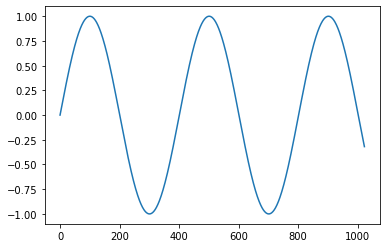

In [2]:
# Function to generate a sine wave
def generate_sine_wave(N, sr, freq):
    """
    Generate a sine wave with the given number of samples, sample-rate, and frequency.
    
    Parameters
    ----------
    N : int
         The number of samples to return.
         
    sr : int
         The sample-rate for the returned signal, in Hz.
         
    freq : float
        The frequency for the returned signal, in Hz.
        
    Returns
    -------
    x : np.array(float)
        N samples of a sine wave with frequency freq, sampled at sr Hz.
    """
    return np.sin(np.arange(N) * 2 * np.pi * freq / sr)


# Sample rate of signal (Hz)
sr = 22050

# Number of samples in signal
N = 5 * sr

# Frequency of sine wave (Hz)
freq = 55

# Generate the sine wave
A1 = generate_sine_wave(N, sr, freq)

# View signal
def WAV(arr, N=2 ** 10, sr=sr, norm=False):
    plt.plot(arr[:N])
    display(Audio(arr, rate=sr, normalize=norm))

WAV(A1)

### Decreasing the amplitude
The membrane of your speaker/headphones is oscillating between the max values -1 and 1. What do you expect when you decrease the amplitude? Decrease it by 75%, 50%, and 25% and listen to the outcomes. Do they meet your expectation?

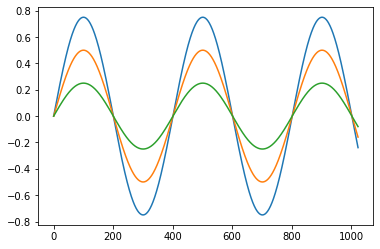

In [3]:
WAV(0.75 * A1)
WAV(0.5 * A1)
WAV(0.25 * A1)

**Answer: 1/2 the amplitude is much softer than 1/2 the loudness.**

### Generate the chord tones and add them together

Let's take the generated sine `A1` as chord root and create three more samples of the same length, namely the 3rd, 5th and 7th harmonic. Display them and listen to them.

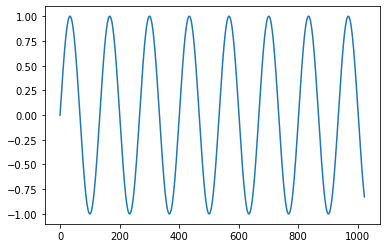

In [4]:
third = generate_sine_wave(N, sr, 3 * freq)
WAV(third)

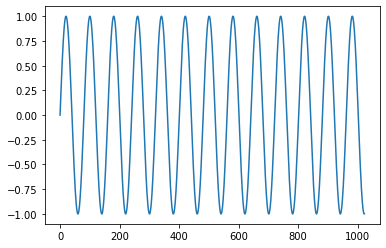

In [5]:
fifth = generate_sine_wave(N, sr, 5 * freq)
WAV(fifth)

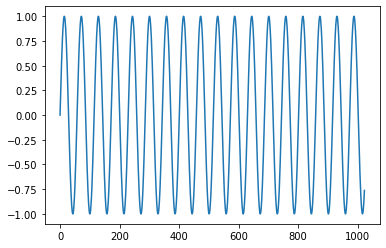

In [6]:
seventh = generate_sine_wave(N, sr, 7 * freq)
WAV(seventh)

### Add them together

Create two samples, one with all four sines and one without the seventh. Listen to them. How can you explain the result?

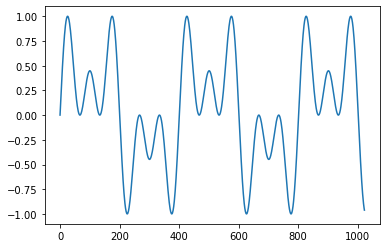

In [7]:
def norm(wav):
    return wav / max(wav.max(), -wav.min())

three = norm(A1 + third + fifth)
WAV(three)

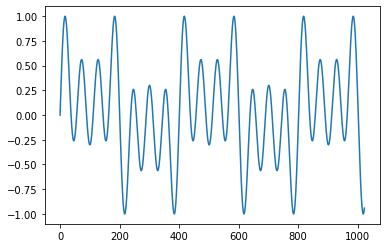

In [8]:
four = norm(three + seventh)
WAV(four)

**Answer: Human auditory perception has the tendency to perceive overtone spectrums (harmonic spectrums) as one fundamental frequency with a certain timbre.**

### Produce sine mixes

Write a function that takes a frequency, a sample rate, a sample length (note the two different meanings of sample!) and a dictionary with amplitudinal weights of the harmonics you want the sample to contain. Use the function to produce a new sample with the same frequencies as before but where each of them is a fundamental that has its own harmonics. Try out different harmonic spectra over the three/four fundamentals by choosing and weighing different combinations.

In [9]:
def norm(wav):
    return wav / max(wav.max(), -wav.min())

def sine_mix(freq, weights, sr=sr, length=5):
    N = length * sr
    components = np.array([weight * generate_sine_wave(N, sr, harmonic * freq) for harmonic, weight in weights.items() if harmonic > 0])
    return norm(components.sum(axis=0))

def sine_chord(freqs, weights, sr=sr, length=5):
    chord = np.array([sine_mix(freq, weights, sr, length) for freq in freqs])
    return norm(chord.sum(axis=0))

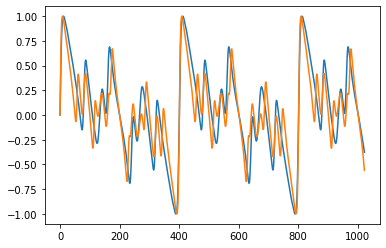

In [10]:
f = 55
three_f = [i*f for i in [1,3,5]]
four_f = [i*f for i in [1,3,5,7]]
#weights = {i: 1 for i in range(8)}                                           # 7 equally weighted harmonics
#weights = {**{1:1}, **{i: 0.1 for i in range(2,8)}}                          # strong fundamental, + 6 weak harmonics
#weights = {i+1: weight for i, weight in enumerate(np.linspace(1, 0, 8))}     # 7 linearly decaying harmonics
#weights = {i + 1: 0.5**i for i in range(7)}                                  # 7 exponentially decaying harmonics                               
#weights = {2*i + 1: 0.5**i for i in range(7)}                                # 7 exponentially decaying uneven harmonics                               
weights = {i+1: weight for i, weight in enumerate(np.logspace(0, -10, 8, base=1.5))}     # 7 logarithmically decaying harmonics
#weights = {i+1: weight for i, weight in enumerate(np.logspace(0, -10, 20, base=2))}      # 20 logarithmically decaying harmonics
thr = sine_chord(three_f, weights)
fou = sine_chord(four_f, weights)
WAV(thr)
WAV(fou)

## Short-time Fourier Transform (STFT)

In [11]:
def plot_stft(X, f=None, t=None, f_min=None, f_max=None, t_min=None, t_max=None, log_freq=False, plot_phase=False):
    """
    Plot the phase and magnitude of a given stft result.
    
    Parameters
    ----------
    X : np.ndarray
        The stft result, complex values.
        
    f : np.array
        A list of the frequencies (Hz) corresponding to the first axis of the stft result,
        if known.
        
    t : np.array
        A list of the times (s) corresponding to the second axis of the stft result,
        if known.
        
    f_min : float
        The minimum frequency to be displayed in the plot. This will be clipped to min(f).
        
    f_max : float
        The maximum frequency to be displayed in the plot. This will be clipped to max(f).
        
    t_min : float
        The minimum time to be displayed in the plot. This will be clipped to min(t).
        
    t_max : float
        The maximum time to be displayed in the plot. This will be clipped to max(t).
        
    log_freq : boolean
        Set the frequence axis to log scale.
        
    plot_phase : boolean
        Plot the phase of the spectrogram.
    """
    ###################
    # Parse input
    ###################
    
    # Set up f and t as simple ranges if not given
    f_given = not f is None
    t_given = not t is None
    if f is None:
        f = np.arange(X.shape[0] + 1) - 0.5
    else:
        f = np.append([f[0] - (f[1] - f[0])], f) + ((f[1] - f[0]) / 2)
    if t is None:
        t = np.arange(X.shape[1] + 1) - 0.5
    else:
        t = np.append([t[0] - (t[1] - t[0])], t) + ((t[1] - t[0]) / 2)
    
    
    ##################
    # Get magnitude and phase of result
    ##################
    
    magnitude = np.abs(X)
    phase = np.angle(X)
    
    
    ###################
    # PLOTTING
    ###################
    
    # Create figure
    fig, axs = plt.subplots(1, 2 if plot_phase else 1, figsize=(20,5))
    
    # Plot magnitude
    mag_axis = axs[0] if plot_phase else axs
    mag_axis.pcolormesh(t, f, magnitude)
    mag_axis.set_title("Magnitude")
    mag_axis.set_xlabel(f"time ({'s' if t_given else 'frame'})")
    mag_axis.set_ylabel(f"frequency {'(Hz)' if f_given else 'bin'}")
    mag_axis.set_xlim(t_min, t_max)
    if log_freq:
        mag_axis.set_yscale('log')
        if f_min is not None:
            f_min = np.log10(f_min)
        if f_max is not None:
            f_max = np.log10(f_max)
    mag_axis.set_ylim(f_min, f_max)
    
    if plot_phase:
        # Plot phase
        axs[1].pcolormesh(t, f, phase)
        axs[1].set_title("Phase")
        axs[1].set_xlabel(f"time ({'s' if t_given else 'frame'})")
        axs[1].set_ylabel(f"frequency {'(Hz)' if f_given else 'bin'}")
        axs[1].set_ylim(f_min, f_max)
        axs[1].set_xlim(t_min, t_max)
        if log_freq:
            axs[1].set_yscale('log')
    
    #fig.show()

### Show spectograms

Turn the example code below into a function and find good parameters to plot the samples that you generated above: `three`, `four` and the different versions of chords you constructed of three or four fundamentals.

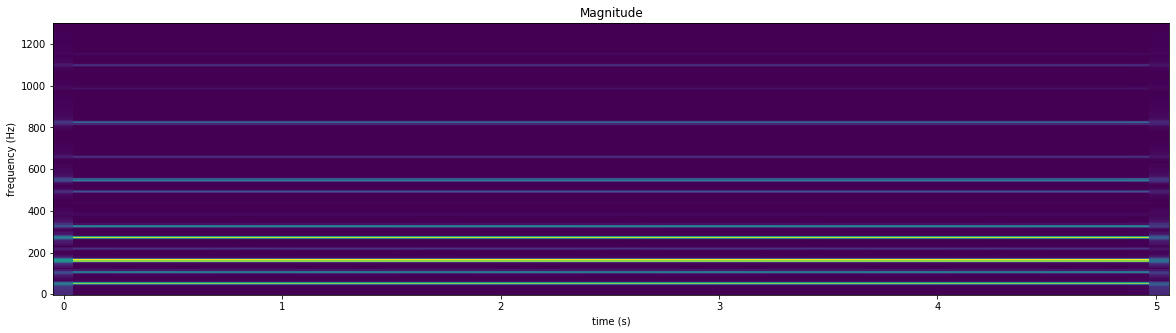

In [12]:
def make_stft(wav, nperseg=256, noverlap=None, nfft=None, window='hann', sr=sr, **kwargs):
    f, t, X = signal.stft(wav,                  # Input signal
                          fs=sr,              # Sample rate (Frequency of Sampling)
                          window=window,      # Window shape
                          nperseg=nperseg,        # Window length
                          noverlap=noverlap,      # How much overlap per window (default: nperseg / 2)
                          nfft=nfft)          # Length of fft (after 0-padding, default: nperseg)

    plot_stft(X, f=f, t=t, **kwargs)

make_stft(thr, 4096, f_max=1300)

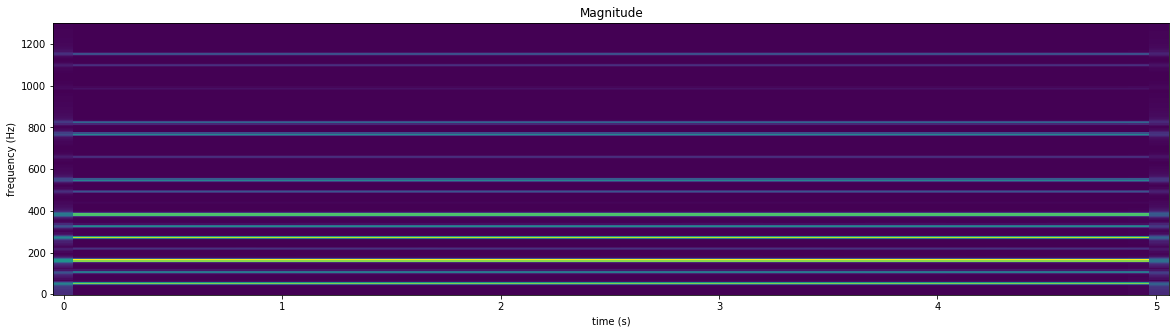

In [13]:
make_stft(fou, 4096, f_max=1300)

## Constant-Q transform

Here, you group frequencies into (usually 12) bins in order to detect pitches. Repeat the above task of finding the right parameters displaying the samples you have created.

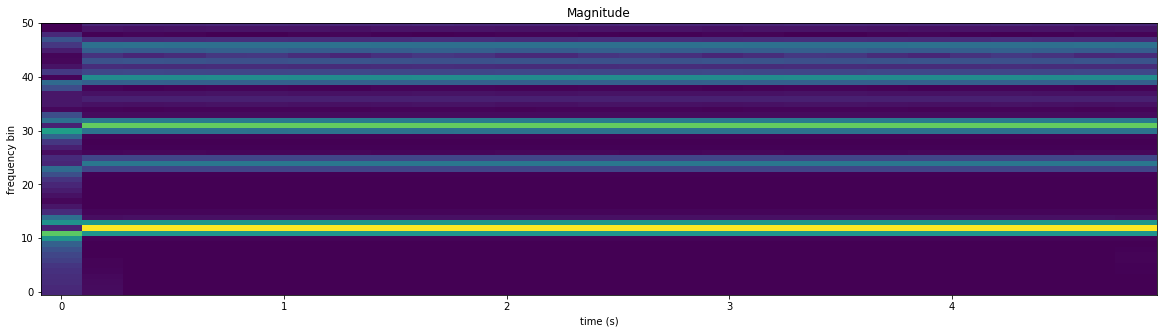

In [14]:
def make_cqt(wav, hop_length=512, bins_per_octave=12, n_bins=90, fmin=27.5, sr=sr, **kwargs):
    X = librosa.core.cqt(wav,
                         sr=sr,
                         hop_length=hop_length,
                         bins_per_octave=bins_per_octave,
                         n_bins=n_bins,
                         fmin=fmin)
    plot_stft(X, t=np.arange(X.shape[1]) / sr * hop_length, **kwargs)
    
make_cqt(fou, 4096, f_max=50)

**Comment: Since `fmin` is the frequency of A0, the peak at bin 12 (an octave higher) shows our chord's root A1. 24 is it's second harmonic which corresponds to A2. The second chord tone appears on 31: 7 semitones, or a perfect fifth, above 24, it corresponds to E3. We expect the 5th harmonic, ~C#4, 9 semitones higher on 40 and the 7th harmonic, ~G4, on 46. Although there are local maxima in these bins, we can see that the 5th and the 7th harmonics don't fall perfectly into the equally-sized frequency bins. Compared to today's pianos' equal temperament, most overtones are detuned.**

## Analysing a sample
Here, we are loading a WAV file. **Don't listen to it.** Use your functions for the two above visualisation techniques to find out what it contains. Listen only fter looking at your spectograms to hear whether your guess was correct.

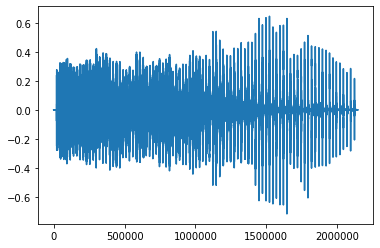

In [15]:
sr, sample = scipy.io.wavfile.read('audio/sample.wav')
sample = sample / 32768 # Read as 16-bit integers, rather than floats
plt.plot(sample);

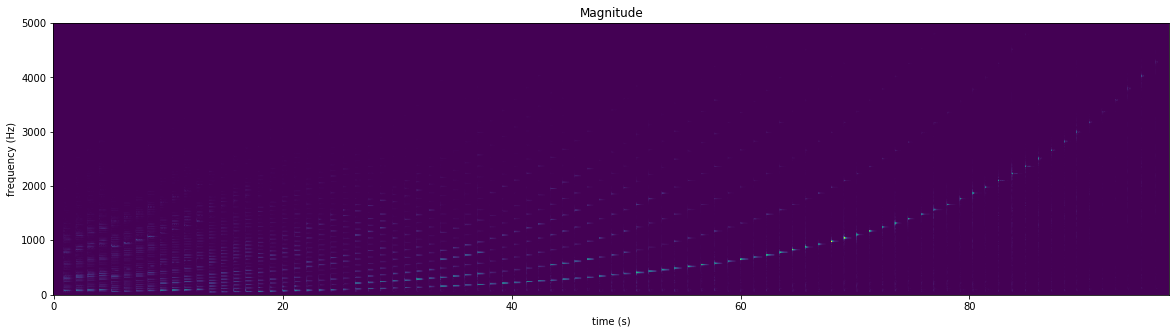

In [16]:
make_stft(sample, 2048, f_max=5000, sr=sr)

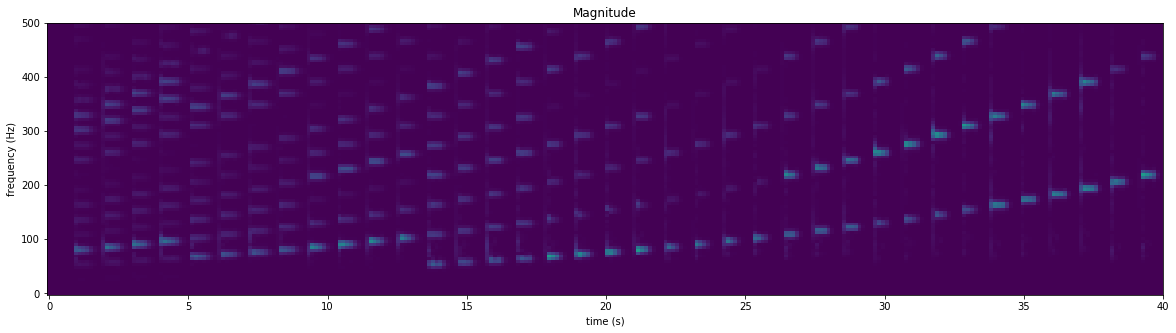

In [17]:
make_stft(sample, 4096, noverlap=1024, f_max=500, t_max=40, sr=sr)

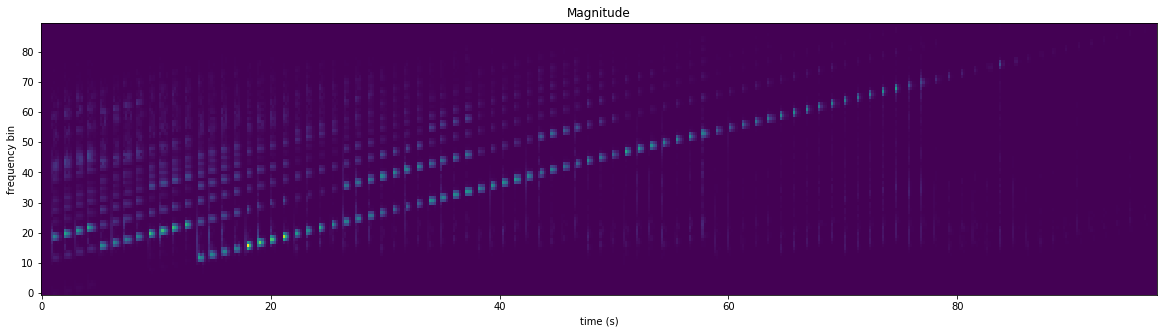

In [24]:
make_cqt(sample, 4096, sr=sr)

**Answer: We see some form of chromatic scale with relatively similar spectra above every note. Also we see the difference between the chromatic scale's frequencies when plotted on a linear (SFTF) or logarithmic (CQT) frequency scale.**

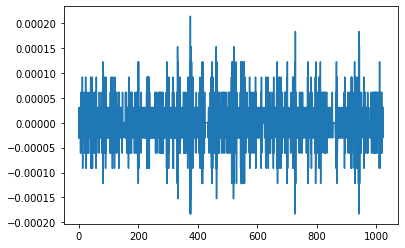

In [19]:
WAV(sample)